In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.datasets import load_iris
import os

In [2]:
plot_dir = r"C:\Users\alepa\Desktop\Data Science\[1] 2nd Semester\Optimization for Data Science\Homework\Plots"
os.makedirs(plot_dir, exist_ok=True)
device = torch.device('cpu')

In [3]:
lr = 3e-3
epochs = 20000
PAT = 20
TOL = 1e-2

In [4]:
torch.manual_seed(13)

In [5]:
def f(X, A, Z):
    logits = torch.mm(A, X)
    log_probs = -F.log_softmax(logits, dim=1)
    loss = (log_probs * Z).sum() / Z.sum()
    return loss


def P(X, A):
    return F.softmax(torch.mm(A, X), dim=1)


def gradient(X, A, Z):
    logits = torch.mm(A, X)
    probs = F.softmax(logits, dim=1)
    grad = torch.mm(A.t(), probs - Z)
    return grad

In [6]:
def ACC(X, A, b_i):
    with torch.no_grad():
        logits = torch.mm(A, X)
        predictions = torch.argmax(logits, dim=1)
        accuracy = (predictions == b_i).float().mean().item()
    return accuracy

In [7]:
def GD(X, A, Z, b_i, epochs, lr, PAT, TOL):
    accuracies = []
    times = []
    epochs_list = []
    start_time = time.process_time()

    best_accuracy = 0
    patience_counter = 0

    for epoch in range(epochs):
        update = gradient(X, A, Z)
        X -= lr * update

        current_time = time.process_time() - start_time
        accuracy = ACC(X, A, b_i)
        accuracies.append(accuracy)
        times.append(current_time)
        epochs_list.append(epoch)

        grad_norm = torch.norm(update).item()

        if grad_norm < TOL:
            patience_counter += 1
        else:
            patience_counter = 0

        if patience_counter >= PAT:
            print(f"Early stopping at epoch {epoch + 1} due to minimal gradient norm.")
            break

    return accuracies, epochs_list, times


def BCGD_randomized(X, A, Z, b_i, epochs, lr, block_size, PAT, TOL):
    accuracies = []
    times = []
    epochs_list = []
    start_time = time.process_time()

    best_accuracy = 0
    patience_counter = 0

    for epoch in range(epochs):
        block_indices = torch.randint(0, X.shape[1], (block_size,)).tolist()
        update_block = gradient(X[:, block_indices], A, Z[:, block_indices])
        X[:, block_indices] -= lr * update_block

        current_time = time.process_time() - start_time
        accuracy = ACC(X, A, b_i)
        accuracies.append(accuracy)
        times.append(current_time)
        epochs_list.append(epoch)

        grad_norm = torch.norm(update_block).item()

        if grad_norm < TOL:
            patience_counter += 1
        else:
            patience_counter = 0

        if patience_counter >= PAT:
            print(f"Early stopping at epoch {epoch + 1} due to minimal gradient norm.")
            break

    return accuracies, epochs_list, times


def BCGD_Gauss_Southwell(X, A, Z, b_i, epochs, lr, block_size, PAT, TOL):
    accuracies = []
    times = []
    epochs_list = []
    start_time = time.process_time()

    best_accuracy = 0
    patience_counter = 0

    for epoch in range(epochs):
        norms = torch.norm(gradient(X, A, Z), dim=0)
        _, block_indices = torch.topk(norms, block_size, largest=True)
        update_block = gradient(X[:, block_indices], A, Z[:, block_indices])
        X[:, block_indices] -= lr * update_block

        current_time = time.process_time() - start_time
        accuracy = ACC(X, A, b_i)
        accuracies.append(accuracy)
        times.append(current_time)
        epochs_list.append(epoch)

        grad_norm = torch.norm(update_block).item()

        if grad_norm < TOL:
            patience_counter += 1
        else:
            patience_counter = 0

        if patience_counter >= PAT:
            print(f"Early stopping at epoch {epoch + 1} due to minimal gradient norm.")
            break

    return accuracies, epochs_list, times

In [8]:
def hessian(A):
    d, m = A.shape
    H = torch.zeros(m, m, device=device)

    for i in range(d):
        x = A[i].view(-1, 1)
        H += torch.mm(x, x.t())

    return H


def lipschitz_hessian(A):
    H = hessian(A)
    L = torch.svd(H).S.max()
    return L


def compute_block_stepsize(A, block_indices):
    col_norms = torch.norm(A[:, block_indices], dim=0) ** 2
    return 0.1 * (1 / col_norms)

In [9]:
def RES(X_init, A, Z, b_i, epochs, block_size, alpha_fixed, PAT, TOL):
    results = {'GD': {}, 'BCGD_randomized': {}, 'BCGD_Gauss_Southwell': {}}

    X_fixed = X_init.clone()
    results['GD']['Fixed'] = GD(X_fixed, A, Z, b_i, epochs, alpha_fixed, PAT, TOL)
    X_fixed = X_init.clone()
    results['BCGD_randomized']['Fixed'] = BCGD_randomized(X_fixed, A, Z, b_i, epochs, alpha_fixed, block_size, PAT, TOL)
    X_fixed = X_init.clone()
    results['BCGD_Gauss_Southwell']['Fixed'] = BCGD_Gauss_Southwell(X_fixed, A, Z, b_i, epochs, alpha_fixed, block_size,
                                                                    PAT, TOL)

    alpha_block_value = compute_block_stepsize(A, torch.arange(X_init.shape[1])).mean().item()
    X_block = X_init.clone()
    results['GD']['Block'] = GD(X_block, A, Z, b_i, epochs, alpha_block_value, PAT, TOL)
    X_block = X_init.clone()
    results['BCGD_randomized']['Block'] = BCGD_randomized(X_block, A, Z, b_i, epochs, alpha_block_value, block_size,
                                                          PAT, TOL)
    X_block = X_init.clone()
    results['BCGD_Gauss_Southwell']['Block'] = BCGD_Gauss_Southwell(X_block, A, Z, b_i, epochs, alpha_block_value,
                                                                    block_size, PAT, TOL)

    return results, alpha_fixed, alpha_block_value

In [10]:
def plot_results(results, plot_name, plot_type='epochs'):
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_theme(style="white", palette="bright")

    plt.figure(figsize=(10, 6))

    for algo_name, result in results.items():
        if plot_type == 'epochs':
            accuracies, epochs_list, _ = result
            x_label = 'Epochs'
            x_data = epochs_list
        elif plot_type == 'time':
            accuracies, _, times = result
            x_label = 'CPU Time (s)'
            x_data = times
        else:
            raise ValueError("Invalid plot_type. Use 'epochs' or 'time'.")

        sns.lineplot(x=x_data, y=accuracies, label=algo_name, linewidth=0.75, errorbar=None)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title(f'Accuracy vs {x_label} ({plot_name})', fontsize=16)
    plt.legend()
    plt.show()

In [11]:
def SYNTH():
    d, m, k = 1000, 50, 50
    A = torch.randn(d, m, device=device)
    X = torch.randn(m, k, device=device)
    E = torch.randn(d, k, device=device)
    noised_matrix = torch.mm(A, X) + E
    b_i = torch.argmax(noised_matrix, dim=1)
    Z = torch.zeros(d, k, device=device)
    Z[torch.arange(d), b_i] = 1
    return noised_matrix, X, Z, b_i, k


def MNIST():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2000, shuffle=True)

    def get_batch(loader):
        for images, b_i in loader:
            return images.view(images.shape[0], -1).to(device), b_i.to(device)

    A, Y = get_batch(train_loader)
    k = 10
    d, m = A.shape
    X = torch.randn(m, k, device=device)
    Z = F.one_hot(Y, num_classes=k).float().to(device)
    return A, X, Z, Y, k


def IRIS():
    iris = load_iris()
    A = torch.tensor(iris.data, dtype=torch.float32).to(device)
    labels = torch.tensor(iris.target, dtype=torch.long).to(device)

    d, m = A.shape
    k = len(np.unique(labels))
    X = torch.randn(m, k, device=device)
    b_i = labels
    Z = torch.zeros(d, k, device=device)
    Z[torch.arange(d), b_i] = 1
    return A, X, Z, b_i, k

In [12]:
def Run(dataset_preparation_fn, epochs, block_size, PAT, TOL):
    A, X_init, Z, b_i, k = dataset_preparation_fn()
    d, m = A.shape

    if block_size > m:
        block_size = m

    L = lipschitz_hessian(A)

    alpha_fixed_value = 1 / L

    results, alpha_fixed, alpha_block = RES(X_init, A, Z, b_i, epochs, block_size, alpha_fixed_value, PAT, TOL)

    return results, alpha_fixed, alpha_block

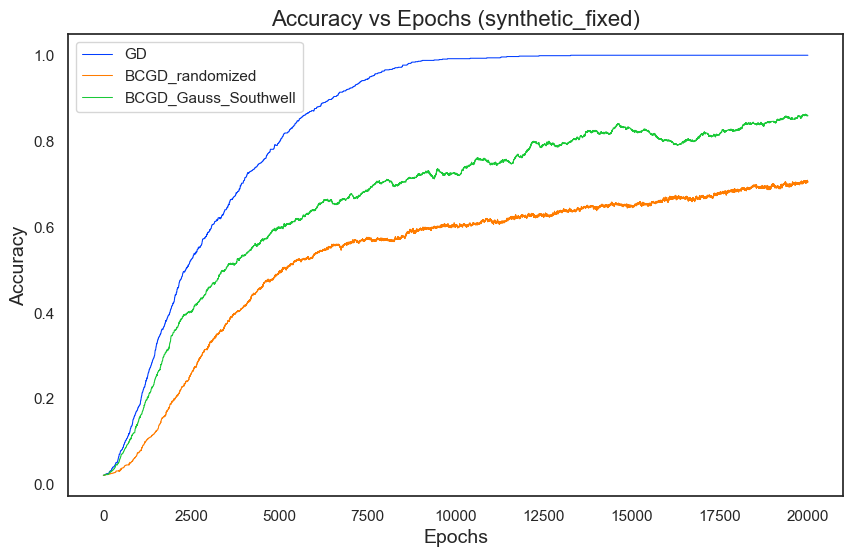

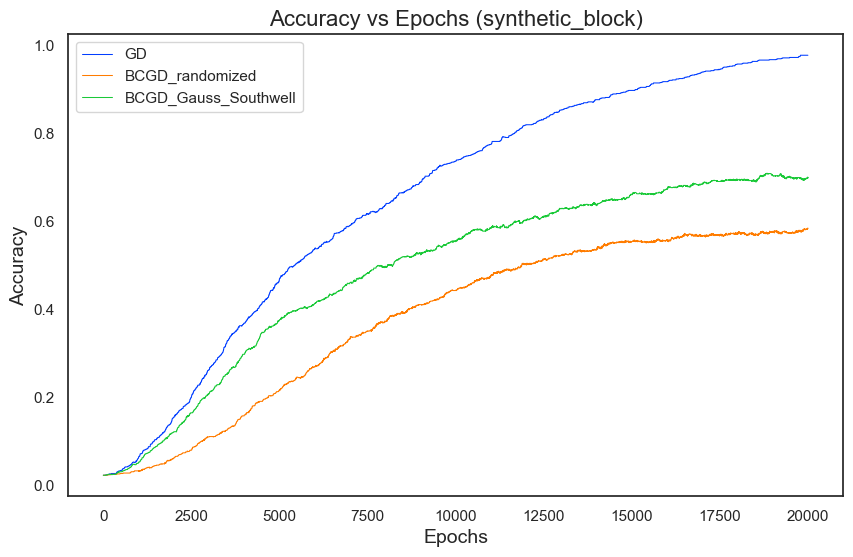

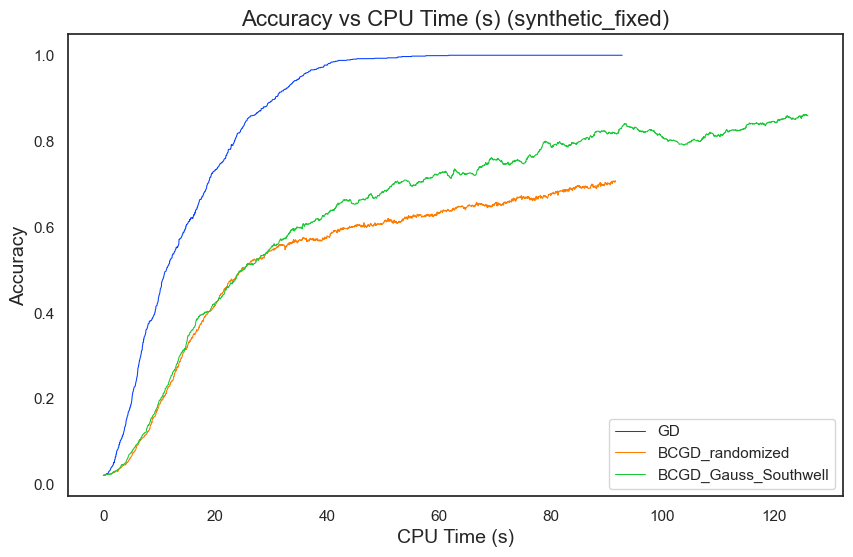

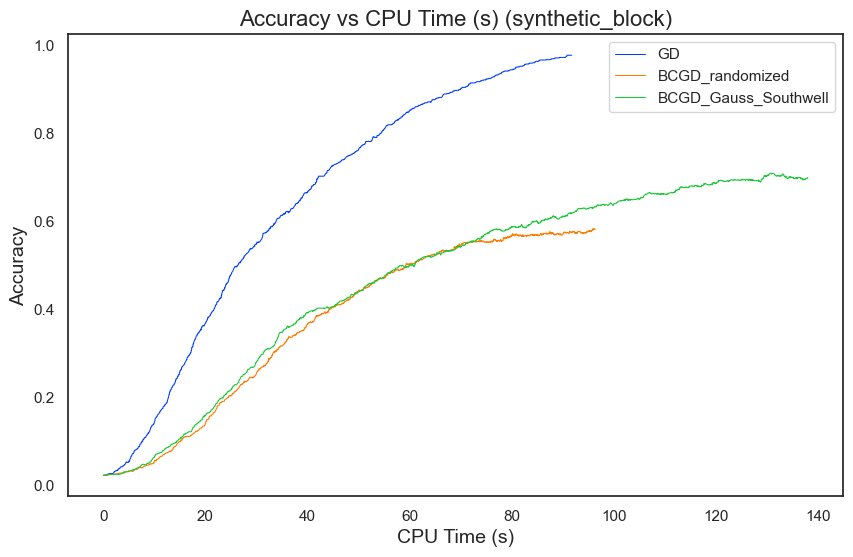

In [13]:
block_size = 35
synthetic_results, fixed_stepsize, block_stepsize = Run(SYNTH, epochs, block_size, PAT, TOL)
plot_results({k: v['Fixed'] for k, v in synthetic_results.items()}, "synthetic_fixed", plot_type='epochs')
plot_results({k: v['Block'] for k, v in synthetic_results.items()}, "synthetic_block", plot_type='epochs')
plot_results({k: v['Fixed'] for k, v in synthetic_results.items()}, "synthetic_fixed", plot_type='time')
plot_results({k: v['Block'] for k, v in synthetic_results.items()}, "synthetic_block", plot_type='time')

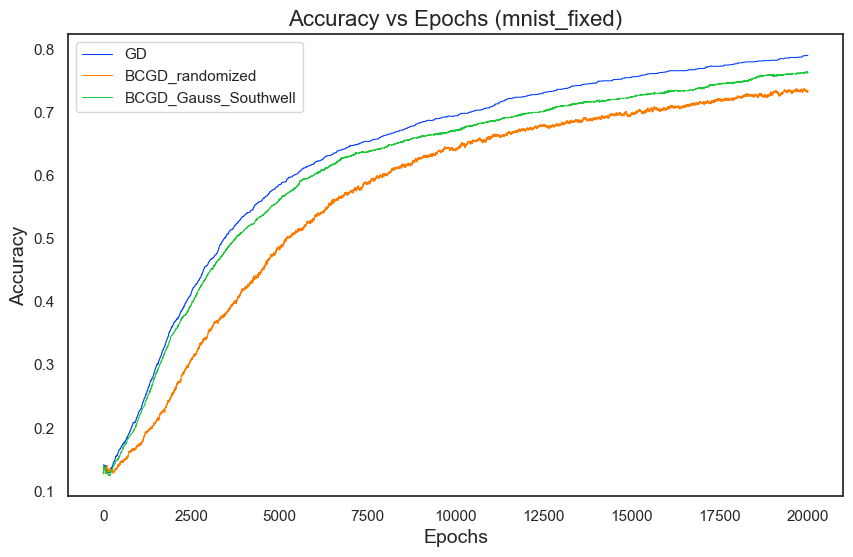

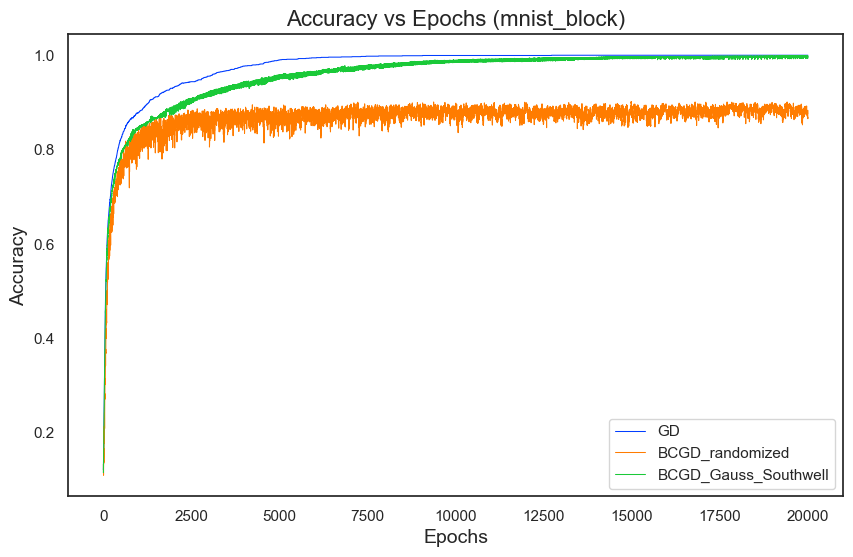

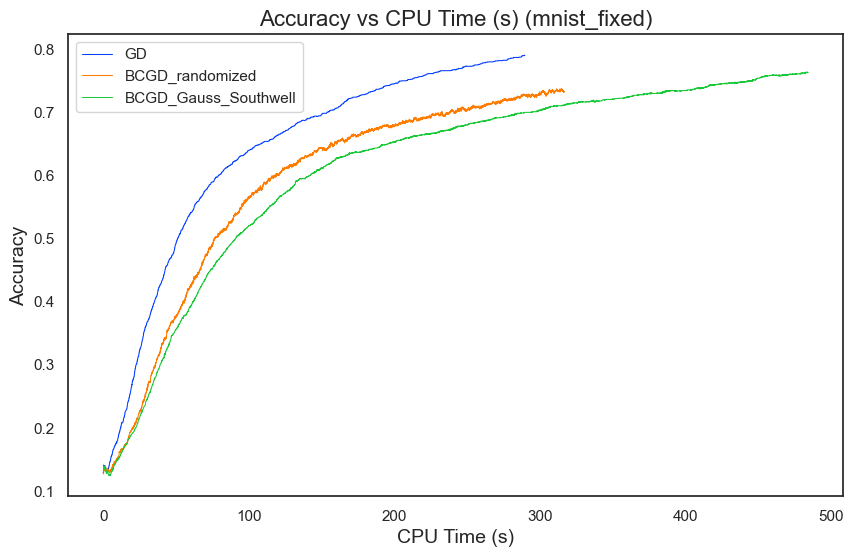

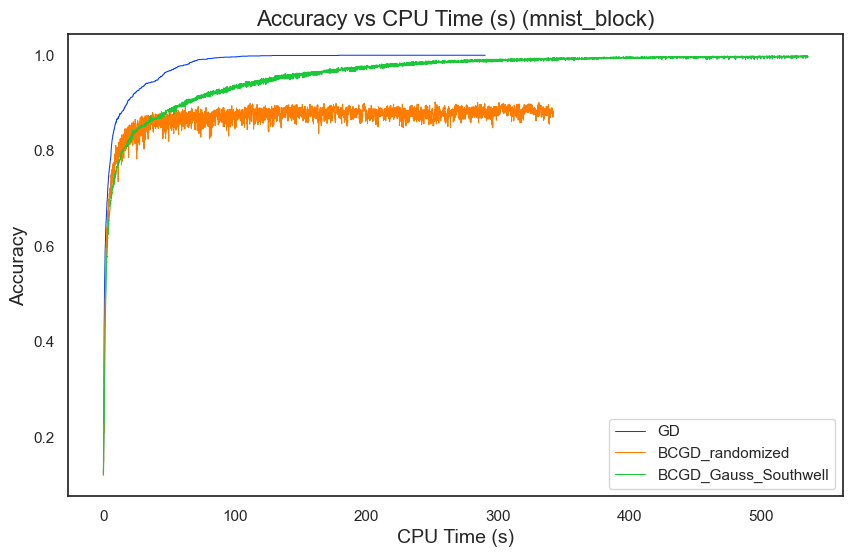

In [14]:
block_size = 9
mnist_results, fixed_stepsize, block_stepsize = Run(MNIST, epochs, block_size, PAT, TOL)
plot_results({k: v['Fixed'] for k, v in mnist_results.items()}, "mnist_fixed", plot_type='epochs')
plot_results({k: v['Block'] for k, v in mnist_results.items()}, "mnist_block", plot_type='epochs')
plot_results({k: v['Fixed'] for k, v in mnist_results.items()}, "mnist_fixed", plot_type='time')
plot_results({k: v['Block'] for k, v in mnist_results.items()}, "mnist_block", plot_type='time')